# ABU量化系统使用文档 

<center>
        <img src="./image/abu_logo.png" alt="" style="vertical-align:middle;padding:10px 20px;"><font size="6" color="black"><b>第30节 趋势跟踪与均值回复的长短线搭配</b></font>
</center>

-----------------

作者: 阿布

阿布量化版权所有 未经允许 禁止转载

[abu量化系统github地址](https://github.com/bbfamily/abu) (欢迎+star)

[本节ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)


上一节讲解了多因子策略并行执行配合的示例，本节讲解趋势跟踪与均值回复的长短线搭配的示例。

首先导入本节需要使用的abupy中的模块： 

In [36]:
# 基础库导入

from __future__ import print_function
from __future__ import division

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/csv


In [37]:
us_choice_symbols = ['usTSLA', 'usNOAH', 'usSFUN', 'usBIDU', 'usAAPL', 'usGOOG', 'usWUBA', 'usVIPS']
cn_choice_symbols = ['002230', '300104', '300059', '601766', '600085', '600036', '600809', '000002', '002594', '002739']
hk_choice_symbols = ['hk03333', 'hk00700', 'hk02333', 'hk01359', 'hk00656', 'hk03888', 'hk02318']

In [38]:
from abupy import AbuDoubleMaBuy, AbuDoubleMaSell, ABuKLUtil, ABuSymbolPd, AbuUpDownTrend, AbuDownUpTrend, AbuUpDownGolden
from abupy import AbuFactorCloseAtrNStop, AbuFactorAtrNStop, AbuFactorPreAtrNStop, tl
from abupy import abu, ABuProgress, AbuMetricsBase, EMarketTargetType, ABuMarketDrawing

在《量化交易之路》中量化入门章节讲过趋势跟踪和均值回复的概念以及策略示例，量化交易系统中策略的原型只有趋势跟踪和均值回复，不管多么复杂的策略最终都会落在这两个基础策略概念范围内。

很多买入策略本身并不能定性为趋势跟踪策略或者均值回复策略，之前的教程一直作为示例使用的海龟突破策略属于一种最简单‘直来直去’的策略，它自身带有明显的趋势跟踪属性，‘直来直去’不代表不好，但是很多时候需要在策略中通过使用非均衡技术进一步构建概率优势，当然这样做也会付出代价，代价就是信号发出的频率会明显降低。

本节将讲解在策略中使用**长短线分析**进一步构建**非均衡概率优势**。

## 1. 长线趋势下跌与短线趋势上涨

* 什么叫做长短线分析？

即把整个择时周期分成两部分，长的为长线择时，短的为短线择时，比如一个示例策略如下：

1. 寻找长线下跌的股票，比如一个季度(4个月)整体趋势为下跌趋势
2. 短线走势上涨的股票，比如一个月整体趋势为上涨趋势
3. 最后使用海龟突破的N日突破策略作为策略最终买入信号

上面文字描述的策略如图所示：

![](./image/du_trend.png)

这种长短线策略一个很大的特点为策略本身并不能定性为趋势跟踪策略或者均值回测策略，决定策略到底为趋势跟踪还是均值回复的主要决定在于卖出策略:

* 使用较大的止盈位置则上述策略定性为趋势跟踪策略，认为短线上涨形成趋势成立，买入后的期望是后期走势可以长时间保持短线目前的上涨趋势
* 使用较小的止盈位置则上述策略定性为均值回复策略，认为短线上涨为长线下跌的回复，买入后的期望是可以短时间内继续保持涨趋势

首先使用较大的止盈位置，则策略定性为趋势跟踪策略，abupy内置的AbuDownUpTrend策略为上述策略的代码实现, 关键策略代码如下:

    def fit_day(self, today):
        """
        长线下跌中寻找短线突破反转买入择时因子
            1. 通过past_today_kl获取长周期的金融时间序列，通过AbuTLine中的is_down_trend判断
            长周期是否属于下跌趋势，
            2. 今天收盘价为最近xd天内最高价格，且短线xd天的价格走势为上升趋势
            3. 满足1，2发出买入信号
        :param today: 当前驱动的交易日金融时间序列数据
        """
        long_kl = self.past_today_kl(today, self.past_factor * self.xd)
        tl_long = AbuTLine(long_kl.close, 'long')
        # 判断长周期是否属于下跌趋势
        if tl_long.is_down_trend(down_deg_threshold=self.down_deg_threshold, show=False):
            if today.close == self.xd_kl.close.max() and AbuTLine(
                    self.xd_kl.close, 'short').is_up_trend(up_deg_threshold=-self.down_deg_threshold, show=False):
                # 今天收盘价为最近xd天内最高价格，且短线xd天的价格走势为上升趋势
                return self.buy_tomorrow()

更多具体实现请阅读源代码，下面做回测示例，如下：

In [39]:
# 初始资金量
cash = 3000000
def run_loo_back(choice_symbols, ps=None, n_folds=3, start=None, end=None, only_info=False):
    """封装一个回测函数，返回回测结果，以及回测度量对象"""
    if choice_symbols[0].startswith('us'):
        abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_US
    else:
        abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_CN
    abu_result_tuple, _ = abu.run_loop_back(cash,
                                           buy_factors,
                                           sell_factors,
                                           ps,
                                           start=start,
                                           end=end,
                                           n_folds=n_folds,
                                           choice_symbols=choice_symbols)
    ABuProgress.clear_output()
    metrics = AbuMetricsBase.show_general(*abu_result_tuple, returns_cmp=only_info, 
                                only_info=only_info,
                                only_show_returns=True)
    return abu_result_tuple, metrics
# 买入策略使用AbuDownUpTrend
buy_factors = [{'class': AbuDownUpTrend}]
# 卖出策略：利润保护止盈策略+风险下跌止损+较大的止盈位
sell_factors = [{'stop_loss_n': 1.0, 'stop_win_n': 3.0,
                 'class': AbuFactorAtrNStop},
                {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
                {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}]
# 开始回测
abu_result_tuple, metrics = run_loo_back(us_choice_symbols, only_info=True)

买入后卖出的交易数量:7
买入后尚未卖出的交易数量:4
胜率:71.4286%
平均获利期望:13.1159%
平均亏损期望:-7.4964%
盈亏比:5.1695
所有交易收益比例和:0.5059 
所有交易总盈亏和:200456.0100 


下面使用plot_candle_from_order接口可视化交易单，以及买入卖出点，如下：

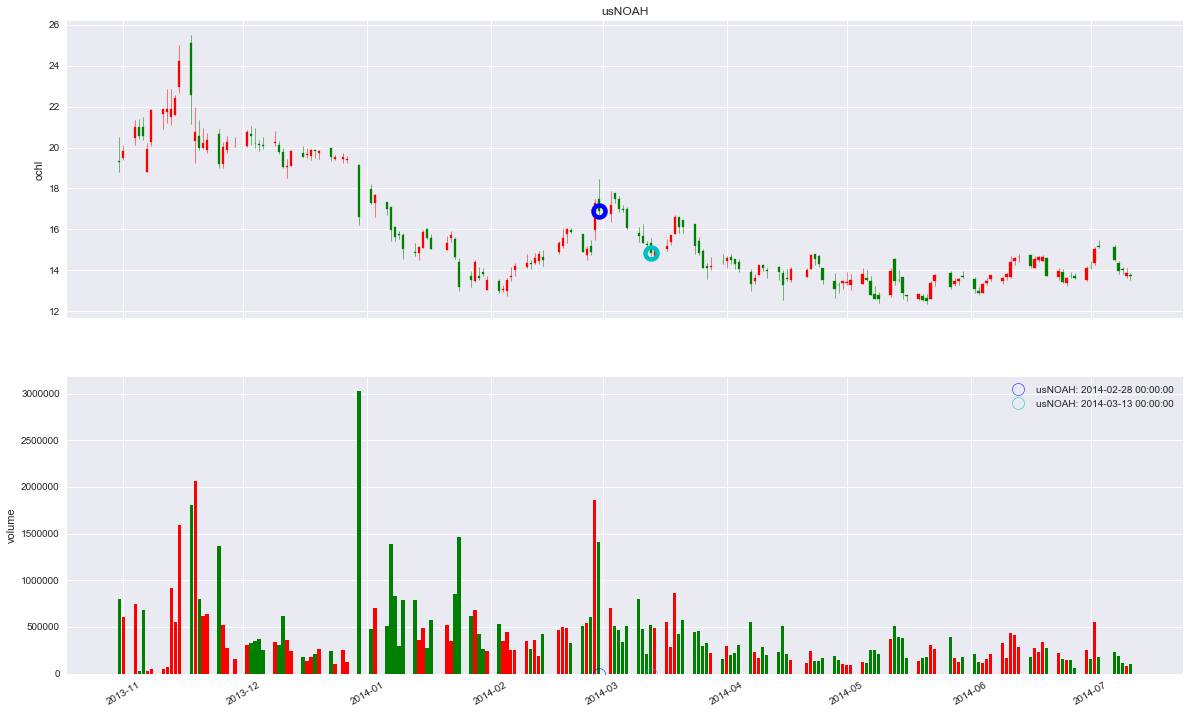

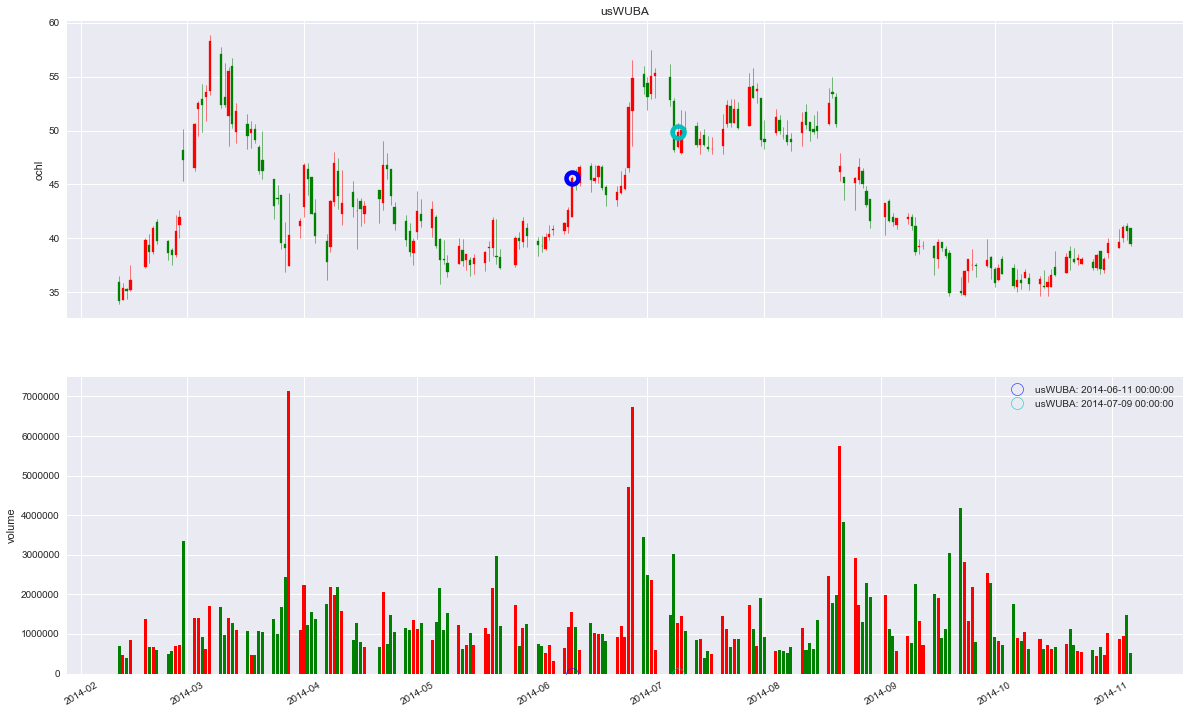

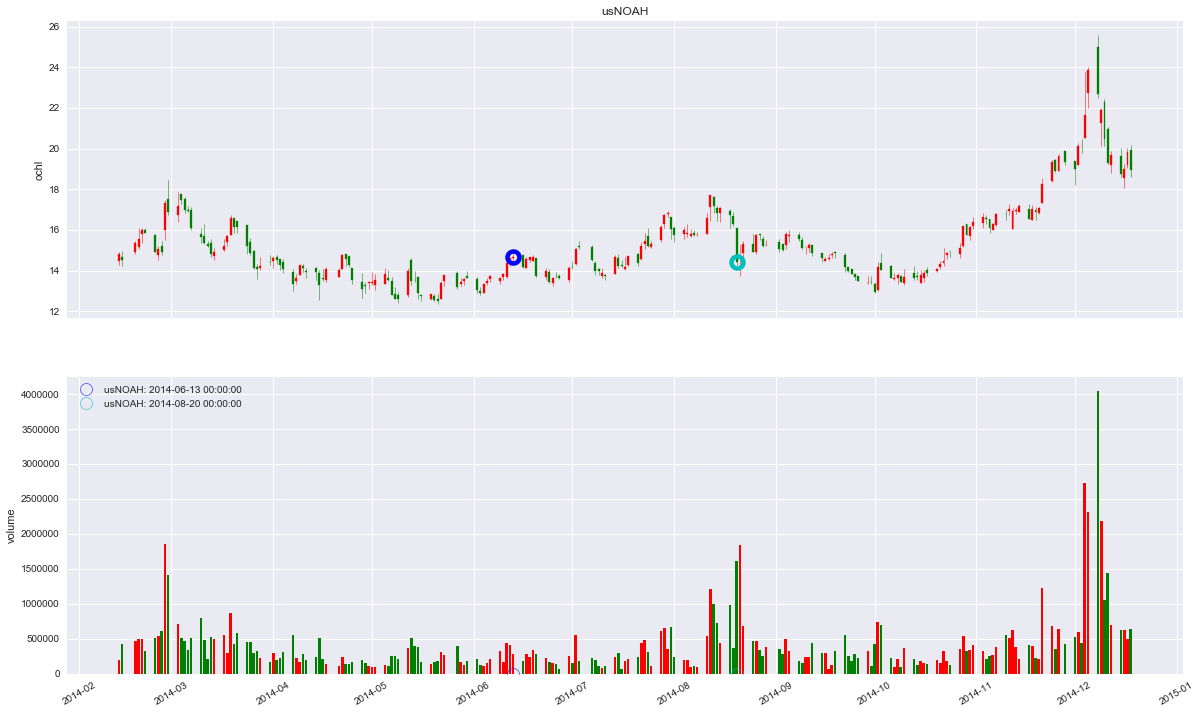

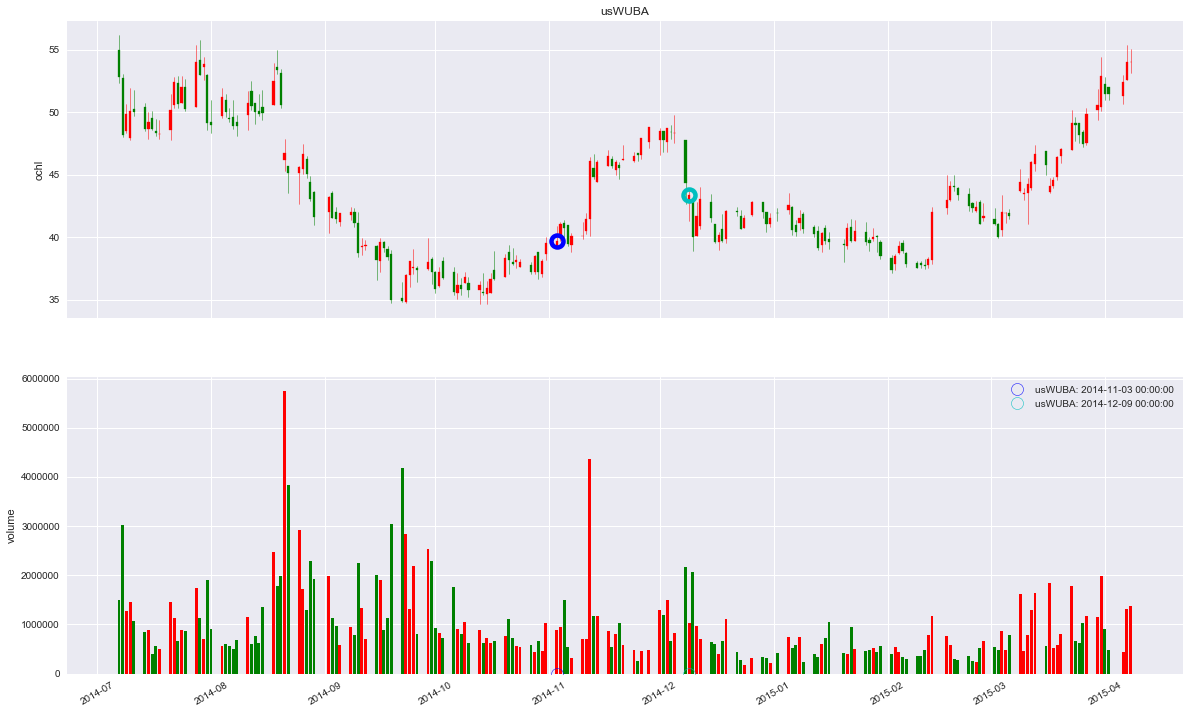

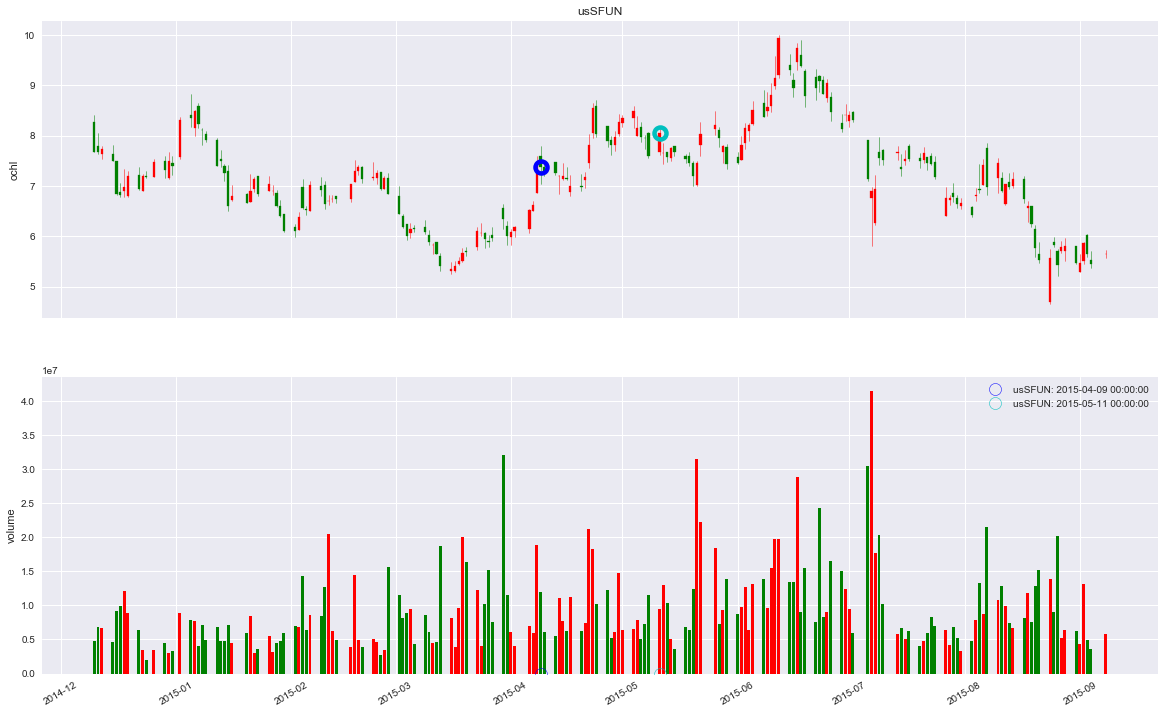

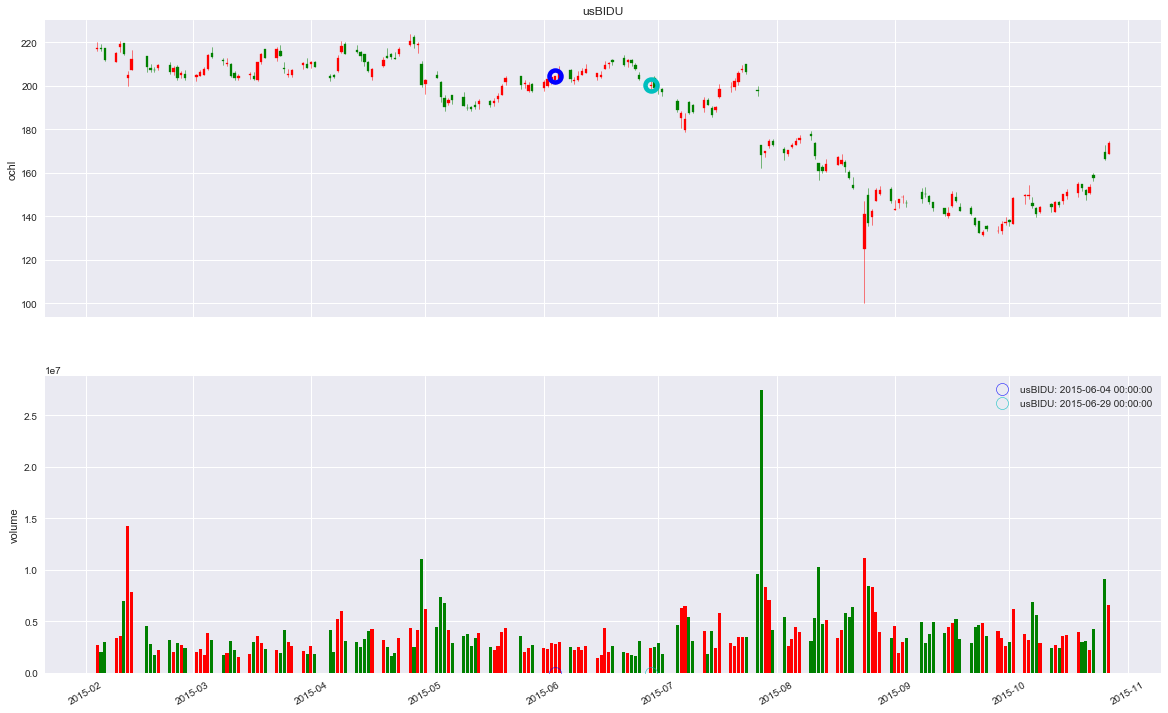

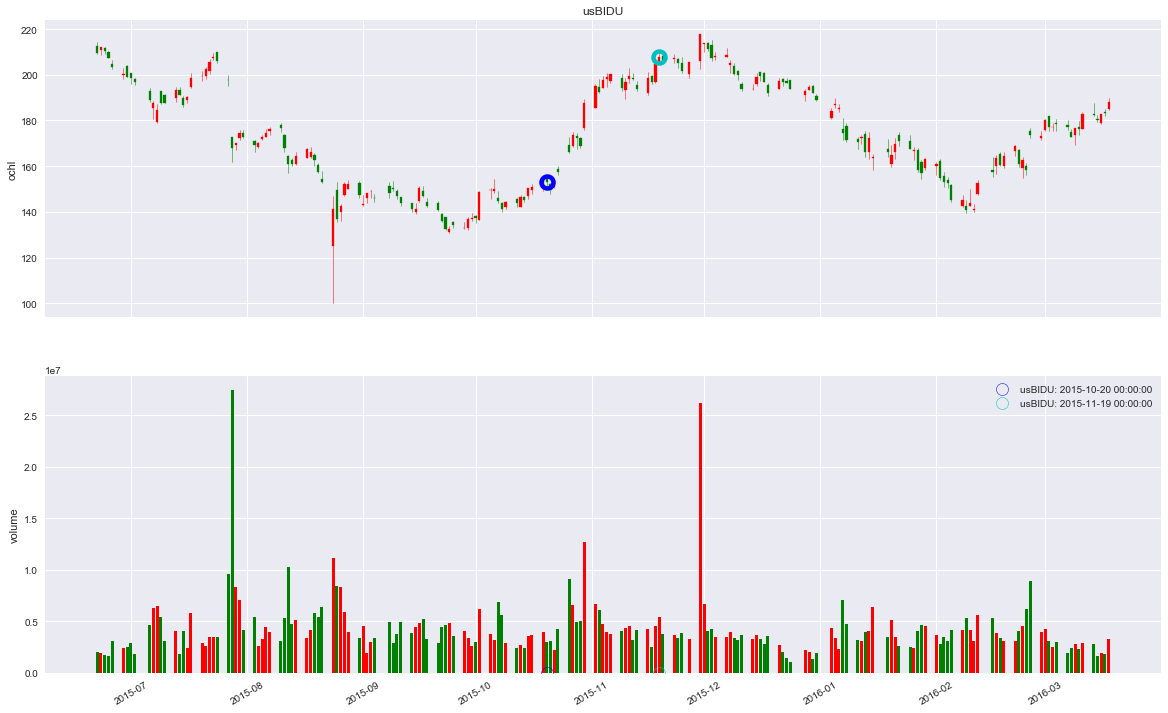

In [40]:
ABuMarketDrawing.plot_candle_from_order(abu_result_tuple.orders_pd)

接下来使用较小的止盈位置则策略定性为均值回复策略，认为短线上涨为长线下跌的回复，买入后的期望是可以短时间内继续保持涨趋势，如下：

In [41]:
# 买入策略不变，卖出策略：利润保护止盈策略+风险下跌止损+较小的止盈位
sell_factors = [{'stop_loss_n': 0.5, 'stop_win_n': 0.5,
                 'class': AbuFactorAtrNStop},
                {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
                {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}]
abu_result_tuple, metrics = run_loo_back(us_choice_symbols, only_info=True)

买入后卖出的交易数量:8
买入后尚未卖出的交易数量:3
胜率:62.5000%
平均获利期望:9.1750%
平均亏损期望:-6.1619%
盈亏比:2.5277
所有交易收益比例和:0.2739 
所有交易总盈亏和:104211.5100 


下面使用相同的策略回测A股市场与港股市场，如下：

In [42]:
abu_result_tuple, metrics = run_loo_back(cn_choice_symbols, only_info=True)

买入后卖出的交易数量:11
买入后尚未卖出的交易数量:0
胜率:54.5455%
平均获利期望:9.3828%
平均亏损期望:-6.2030%
盈亏比:1.5549
所有交易收益比例和:0.2528 
所有交易总盈亏和:52113.5000 


In [43]:
abu_result_tuple, metrics = run_loo_back(hk_choice_symbols, only_info=True)

买入后卖出的交易数量:8
买入后尚未卖出的交易数量:0
胜率:75.0000%
平均获利期望:4.5124%
平均亏损期望:-2.9826%
盈亏比:4.0991
所有交易收益比例和:0.2111 
所有交易总盈亏和:102425.0000 


从上面的回测结果可以发现买入信号发出的频率比‘直来直去’的海龟突破策略要少很多。

因为在上面的策略中通过使用非均衡技术进一步构建概率优势，代价就是形成了一个苛刻的买入策略，但量化交易最大的长处是通过计算机强大的运算能力，在广度上占有绝对优势，通过量化交易在短时间内完成对不同市场进行择时，更可以并行更多的苛刻策略来满足资金规模需求。

## 2. 长线趋势上涨与短线趋势下跌

可以使用各种周期趋势组合来完成不同的买入策略，与上述策略相反的情况是长线趋势上涨，短线趋势下跌：

1. 寻找长线上涨的股票，比如一个季度(4个月)整体趋势为上涨趋势
2. 短线走势下跌的股票，比如一个月整体趋势为下跌趋势
3. 最后使用短线向下突破作为策略最终买入信号


abupy内置的AbuUpDownTrend策略为上述策略的代码实现, 关键策略代码如下:

    def fit_day(self, today):
        """
        长线周期选择目标为上升趋势的目标，短线寻找近期走势为向下趋势的目标进行买入，期望是持续之前长相的趋势
            1. 通过past_today_kl获取长周期的金融时间序列，通过AbuTLine中的is_up_trend判断
            长周期是否属于上涨趋势，
            2. 今天收盘价为最近xd天内最低价格，且短线xd天的价格走势为下跌趋势
            3. 满足1，2发出买入信号
        :param today: 当前驱动的交易日金融时间序列数据
        """
        long_kl = self.past_today_kl(today, self.past_factor * self.xd)
        tl_long = AbuTLine(long_kl.close, 'long')
        # 判断长周期是否属于上涨趋势
        if tl_long.is_up_trend(up_deg_threshold=self.up_deg_threshold, show=False):
            if today.close == self.xd_kl.close.min() and AbuTLine(
                    self.xd_kl.close, 'short').is_down_trend(down_deg_threshold=-self.up_deg_threshold, show=False):
                # 今天收盘价为最近xd天内最低价格，且短线xd天的价格走势为下跌趋势
                return self.buy_tomorrow()

AbuUpDownTrend的实现与AbuDownUpTrend的实现正好相反，但实际上AbuUpDownTrend的最终买入信号存在一定问题，下面先用AbuUpDownTrend做回测，如下：

In [44]:
buy_factors = [{'class': AbuUpDownTrend}]
# 美股沙盒数据回测
abu_result_tuple_us, metrics = run_loo_back(us_choice_symbols, only_info=True)

买入后卖出的交易数量:9
买入后尚未卖出的交易数量:0
胜率:55.5556%
平均获利期望:9.9677%
平均亏损期望:-3.9561%
盈亏比:1.6703
所有交易收益比例和:0.3401 
所有交易总盈亏和:47643.9000 


In [45]:
# A股沙盒数据回测
abu_result_tuple_cn, metrics = run_loo_back(cn_choice_symbols, only_info=True)

买入后卖出的交易数量:14
买入后尚未卖出的交易数量:0
胜率:71.4286%
平均获利期望:9.7103%
平均亏损期望:-14.0535%
盈亏比:2.5651
所有交易收益比例和:0.4089 
所有交易总盈亏和:181897.5000 


In [46]:
# 港股沙盒数据回测
abu_result_tuple_hk, metrics = run_loo_back(hk_choice_symbols, only_info=True)

买入后卖出的交易数量:5
买入后尚未卖出的交易数量:0
胜率:80.0000%
平均获利期望:3.0406%
平均亏损期望:-7.9597%
盈亏比:2.7703
所有交易收益比例和:0.0420 
所有交易总盈亏和:42355.0000 


上面三个市场的回测结果表面上看似乎还不错，因为沙盒中的symbol数量不多，在abupy中有专门针对策略验证可行性的接口模块，在之后的章节会重点讲解示例。

在教程‘第15节 量化交易和搜索引擎’中强调过对交易结果进行人工分析是最常用且有效的手段，即直接可视化交易的买入卖出点及走势，发现策略的问题以及改善方法，下面可视化港股市场回测的几笔交易单如下：

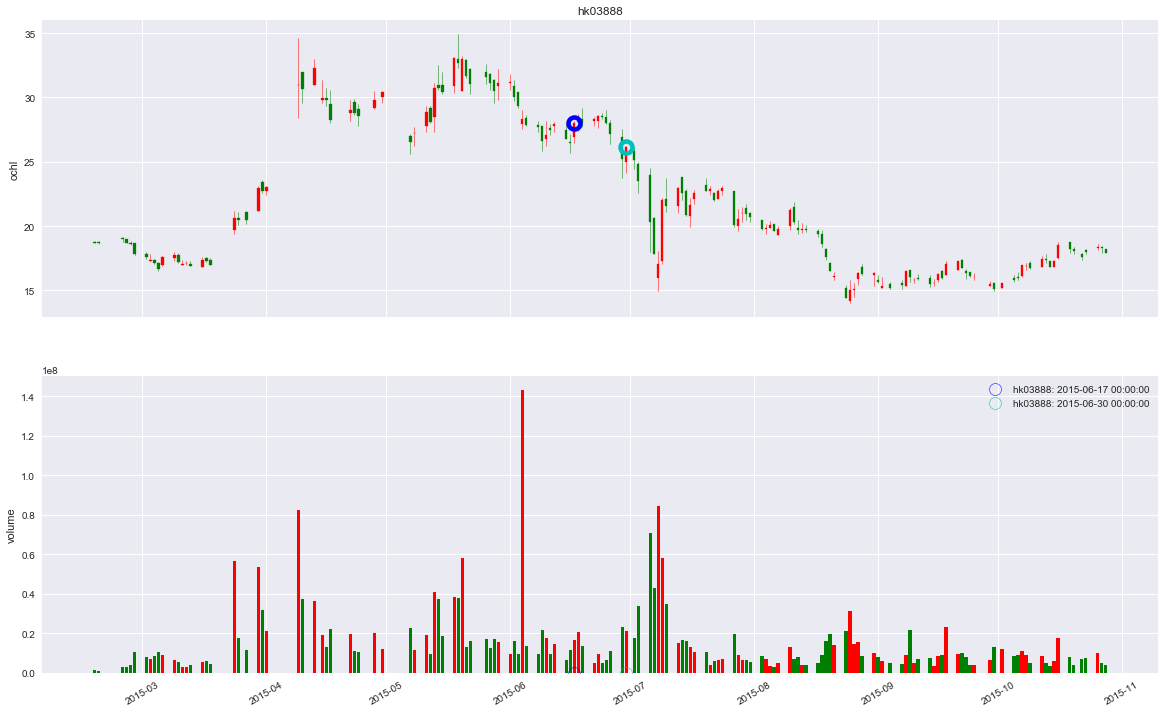

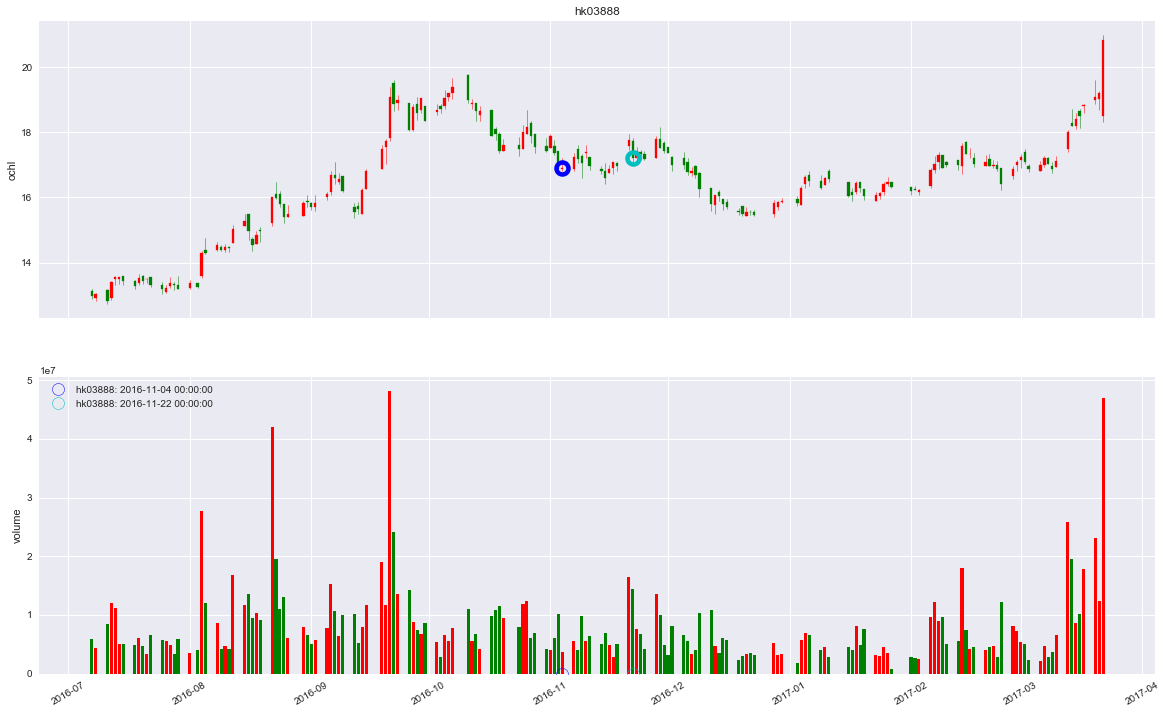

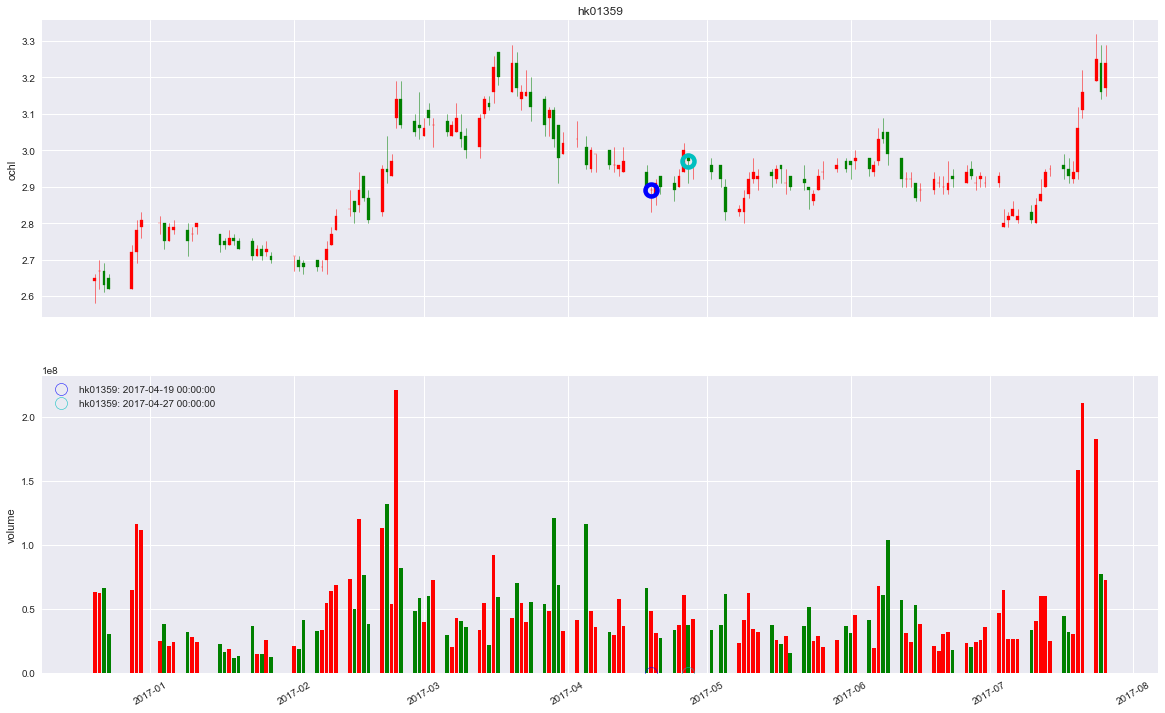

In [47]:
ABuMarketDrawing.plot_candle_from_order(abu_result_tuple_hk.orders_pd.tail(3))

可自行尝试切换abu_result_tuple_cn或者abu_result_tuple_us查看A股，美股的具体交易买卖行为，从买入点分析可以发现大多数买入点可以归结为如下图所示类型，基本上属于上升趋势线破位点：

![](./image/f_trend.png)

归结原因是因为最终的决策信号是通过**今天收盘价为最近xd天内最低价格**, 即一个向下突破做为买入信号，并不能说这个信号本身是不对的，只能说这个信号对于整体策略系统和之后的期望走势是不匹配的，比如策略具体的期望可以是：长线上涨中寻找短线下跌，且有反弹迹象：

![](./image/g_trend.png)


具体的策略上可以使用多种方式实现，比如最终的信号发生使用均线上扬或者黄金分割反弹迹象。

abupy内置的AbuUpDownGolden策略使用黄金分割反弹迹象做为最终的信号发生，描述为：

1. 寻找长线上涨的股票，比如一个季度(4个月)整体趋势为上涨趋势
2. 短线走势下跌的股票，比如一个月整体趋势为下跌趋势
3. 昨天收盘价在0.382下，今天收盘价格在0.382上作为策略最终买入信号

关键策略代码如下，更多请阅读AbuUpDownGolden类源代码：

    def fit_day(self, today):
        """
        长线周期选择目标为上升趋势的目标，短线寻找近期走势为向下趋势的目标进行买入，期望是持续之前长相的趋势
            1. 通过past_today_kl获取长周期的金融时间序列，通过AbuTLine中的is_up_trend判断
            长周期是否属于上涨趋势，
            2. 昨天收盘价在0.382下，今天收盘价格在0.382上，且短线xd天的价格走势为下跌趋势
            3. 满足1，2发出买入信号
        :param today: 当前驱动的交易日金融时间序列数据
        """
        long_kl = self.past_today_kl(today, self.past_factor * self.xd)
        tl_long = AbuTLine(long_kl.close, 'long')
        # 判断长周期是否属于上涨趋势
        if tl_long.is_up_trend(up_deg_threshold=self.up_deg_threshold, show=False):
            # calc_golden计算黄金分割+关键点位值
            golden = calc_golden(self.xd_kl, show=False)
            if today.pre_close < golden.below382 < today.close and AbuTLine(
                    self.xd_kl.close, 'short').is_down_trend(down_deg_threshold=-self.up_deg_threshold,
                                                             show=False):
                # 昨天收盘价在0.382下，今天收盘价格在0.382上，且短线xd天的价格走势为下跌趋势
                return self.buy_tomorrow()

上面策略代码中实现主要通过calc_golden计算了价格趋势的各个关键点位值，包括黄金分割带的值，如下示例计算了tsla一段时间的价格走势分割位：

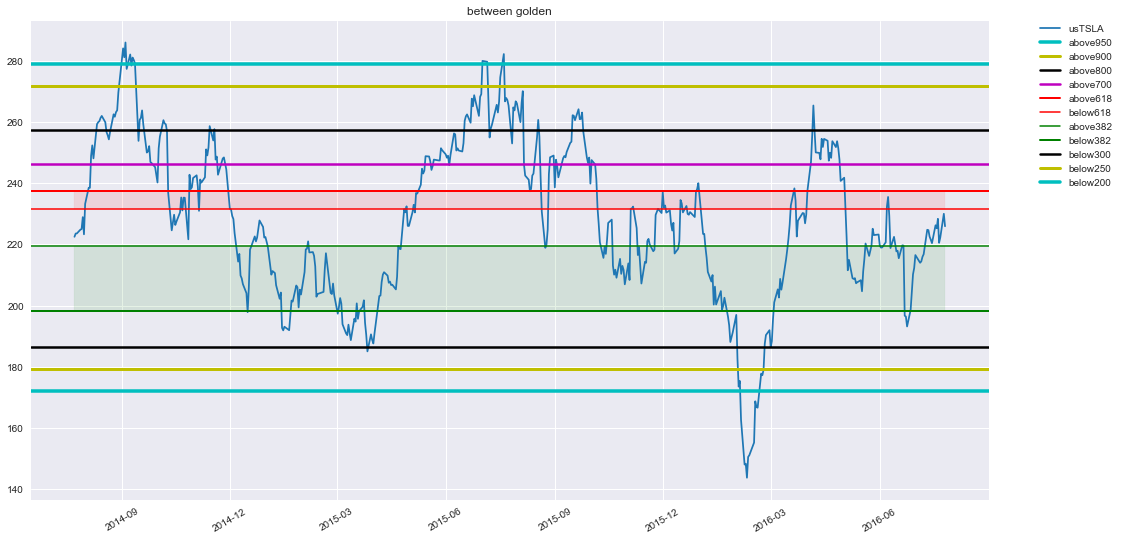

golden(g382=198.05534, gex382=219.62314000000001, g500=214.85500000000002, gex500=227.61500000000001, g618=231.65466000000001, gex618=237.55788000000001, above618=237.55788000000001, below618=231.65466000000001, above382=219.62314000000001, below382=198.05534, above950=278.92150000000004, above900=271.803, above800=257.56600000000003, above700=246.13199999999998, below300=186.381, below250=179.26249999999999, below200=172.14400000000001)

In [48]:
tl.golden.calc_golden(ABuSymbolPd.make_kl_df('usTSLA'))

备注：有很多人说不应该使用黄金分割线，认为黄金分割线没有理论支撑，实际上一直强调的类似求解方程组，如果所有的参数都是未知数，将无法解出答案，所以一定要把一些变量变成常数值，然后通过这些常数值来确定更多的变量，最终解出你所关心的解，黄金分割线值是很好的制造非均衡环境的常数阀值。

下面使用AbuUpDownGolden做为买入策略进行回测，如下：

In [49]:
buy_factors = [{'class': AbuUpDownGolden}]
abu_result_tuple, metrics = run_loo_back(us_choice_symbols, only_info=True)

买入后卖出的交易数量:3
买入后尚未卖出的交易数量:0
胜率:33.3333%
平均获利期望:2.4998%
平均亏损期望:-10.2160%
盈亏比:0.1900
所有交易收益比例和:-0.1793 
所有交易总盈亏和:-55053.6400 


下面从交易结果单子中可视化买卖点，可以看到策略达成了在长线上涨，短线下跌，且有反弹迹象的时候买入：

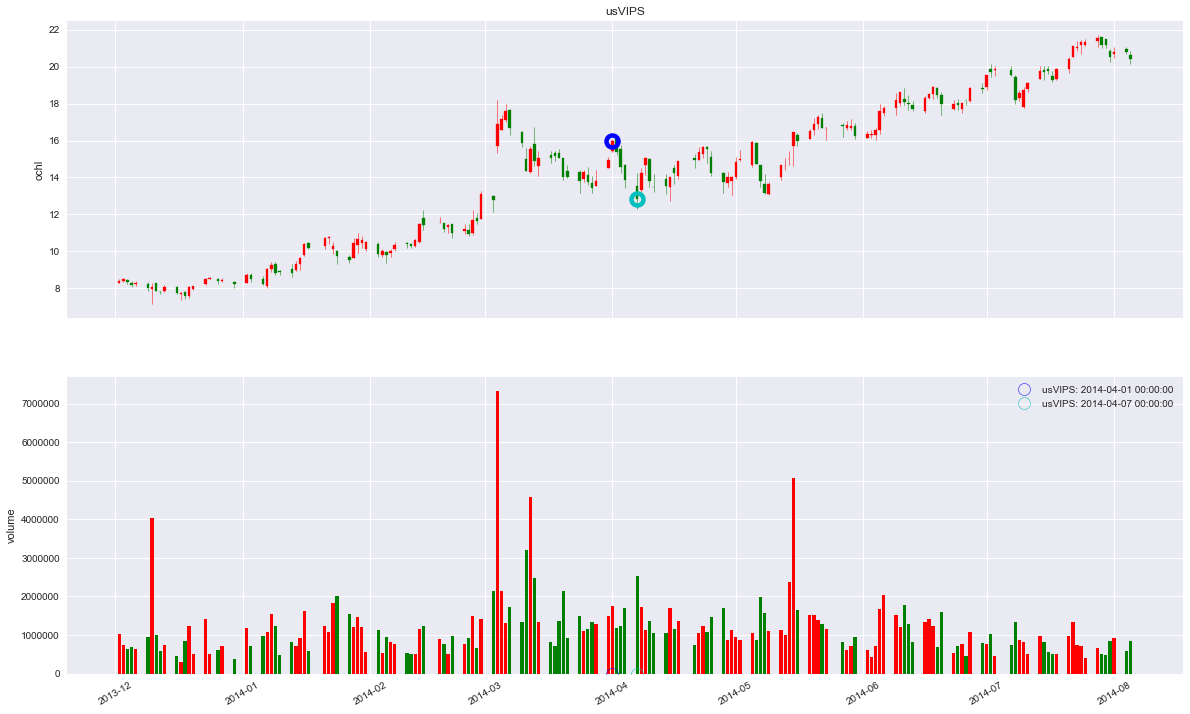

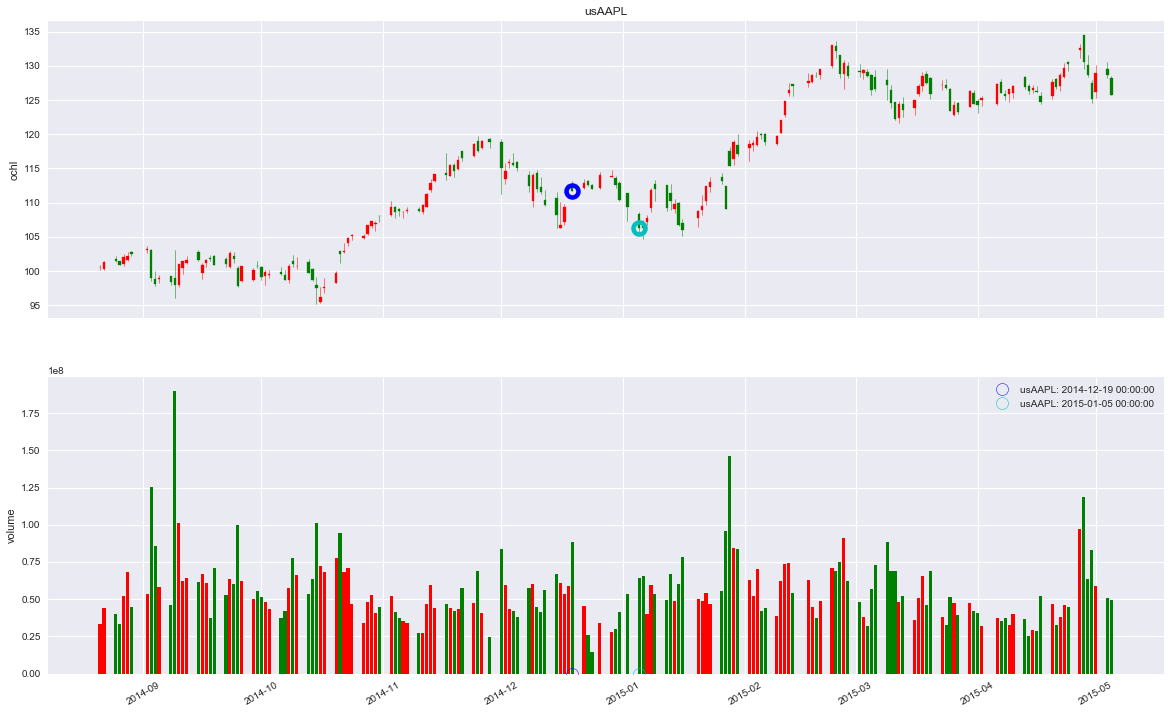

In [50]:
ABuMarketDrawing.plot_candle_from_order(abu_result_tuple.orders_pd.head(2))

下面切换到a股市场进行回测，可以看到由于策略的苛刻条件导致交易数量进一步降低：

In [51]:
abu_result_tuple, metrics = run_loo_back(cn_choice_symbols, only_info=True)

买入后卖出的交易数量:4
买入后尚未卖出的交易数量:0
胜率:75.0000%
平均获利期望:10.7491%
平均亏损期望:-16.4931%
盈亏比:3.0674
所有交易收益比例和:0.1575 
所有交易总盈亏和:67898.0000 


#### abu量化文档目录章节

1. [择时策略的开发](http://www.abuquant.com/lecture/lecture_1.html)
2. [择时策略的优化](http://www.abuquant.com/lecture/lecture_2.html)
3. [滑点策略与交易手续费](http://www.abuquant.com/lecture/lecture_3.html)
4. [多支股票择时回测与仓位管理](http://www.abuquant.com/lecture/lecture_4.html)
5. [选股策略的开发](http://www.abuquant.com/lecture/lecture_5.html)
6. [回测结果的度量](http://www.abuquant.com/lecture/lecture_6.html)
7. [寻找策略最优参数和评分](http://www.abuquant.com/lecture/lecture_7.html)
8. [A股市场的回测](http://www.abuquant.com/lecture/lecture_8.html)
9. [港股市场的回测](http://www.abuquant.com/lecture/lecture_9.html)
10. [比特币，莱特币的回测](http://www.abuquant.com/lecture/lecture_10.html)
11. [期货市场的回测](http://www.abuquant.com/lecture/lecture_11.html)
12. [机器学习与比特币示例](http://www.abuquant.com/lecture/lecture_12.html)
13. [量化技术分析应用](http://www.abuquant.com/lecture/lecture_13.html)
14. [量化相关性分析应用](http://www.abuquant.com/lecture/lecture_14.html)
15. [量化交易和搜索引擎](http://www.abuquant.com/lecture/lecture_15.html)
16. [UMP主裁交易决策](http://www.abuquant.com/lecture/lecture_16.html)
17. [UMP边裁交易决策](http://www.abuquant.com/lecture/lecture_17.html)
18. [自定义裁判决策交易](http://www.abuquant.com/lecture/lecture_18.html)
19. [数据源](http://www.abuquant.com/lecture/lecture_19.html)
20. [A股全市场回测](http://www.abuquant.com/lecture/lecture_20.html)
21. [A股UMP决策](http://www.abuquant.com/lecture/lecture_21.html)
22. [美股全市场回测](http://www.abuquant.com/lecture/lecture_22.html)
23. [美股UMP决策](http://www.abuquant.com/lecture/lecture_23.html)

abu量化系统文档教程持续更新中，请关注公众号中的更新提醒。

#### 《量化交易之路》目录章节及随书代码地址

1. [第二章 量化语言——Python](https://github.com/bbfamily/abu/tree/master/ipython/第二章-量化语言——Python.ipynb)
2. [第三章 量化工具——NumPy](https://github.com/bbfamily/abu/tree/master/ipython/第三章-量化工具——NumPy.ipynb)
3. [第四章 量化工具——pandas](https://github.com/bbfamily/abu/tree/master/ipython/第四章-量化工具——pandas.ipynb)
4. [第五章 量化工具——可视化](https://github.com/bbfamily/abu/tree/master/ipython/第五章-量化工具——可视化.ipynb)
5. [第六章 量化工具——数学：你一生的追求到底能带来多少幸福](https://github.com/bbfamily/abu/tree/master/ipython/第六章-量化工具——数学.ipynb)
6. [第七章 量化系统——入门：三只小猪股票投资的故事](https://github.com/bbfamily/abu/tree/master/ipython/第七章-量化系统——入门.ipynb)
7. [第八章 量化系统——开发](https://github.com/bbfamily/abu/tree/master/ipython/第八章-量化系统——开发.ipynb)
8. [第九章 量化系统——度量与优化](https://github.com/bbfamily/abu/tree/master/ipython/第九章-量化系统——度量与优化.ipynb)
9. [第十章 量化系统——机器学习•猪老三](https://github.com/bbfamily/abu/tree/master/ipython/第十章-量化系统——机器学习•猪老三.ipynb)
10. [第十一章 量化系统——机器学习•ABU](https://github.com/bbfamily/abu/tree/master/ipython/第十一章-量化系统——机器学习•ABU.ipynb)
11. [附录A 量化环境部署](https://github.com/bbfamily/abu/tree/master/ipython/附录A-量化环境部署.ipynb)
12. [附录B 量化相关性分析](https://github.com/bbfamily/abu/tree/master/ipython/附录B-量化相关性分析.ipynb)
13. [附录C 量化统计分析及指标应用](https://github.com/bbfamily/abu/tree/master/ipython/附录C-量化统计分析及指标应用.ipynb)

[更多阿布量化量化技术文章](http://www.abuquant.com/article)


更多关于量化交易相关请阅读[《量化交易之路》](http://www.abuquant.com/books/quantify-trading-road.html)

更多关于量化交易与机器学习相关请阅读[《机器学习之路》](http://www.abuquant.com/books/machine-learning-road.html)

更多关于abu量化系统请关注微信公众号: abu_quant

![](./image/qrcode.jpg)